In [33]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
import scipy
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

              Date    Open   Close    High     Low Change %
0     Jan 27, 2000  1.0019  0.9885  1.0030  0.9869   -1.27%
1     Jan 28, 2000  0.9880  0.9750  0.9895  0.9738   -1.37%
2     Jan 31, 2000  0.9779  0.9695  0.9829  0.9670   -0.56%
3     Feb 01, 2000  0.9704  0.9724  0.9783  0.9663    0.30%
4     Feb 02, 2000  0.9717  0.9765  0.9808  0.9689    0.42%
...            ...     ...     ...     ...     ...      ...
4952  Jan 21, 2019  1.1371  1.1366  1.1409  1.1355    0.03%
4953  Jan 22, 2019  1.1365  1.1359  1.1386  1.1334   -0.06%
4954  Jan 23, 2019  1.1358  1.1381  1.1397  1.1348    0.19%
4955  Jan 24, 2019  1.1380  1.1306  1.1398  1.1287   -0.66%
4956  Jan 25, 2019  1.1306  1.1415  1.1421  1.1298    0.96%

[4957 rows x 6 columns]


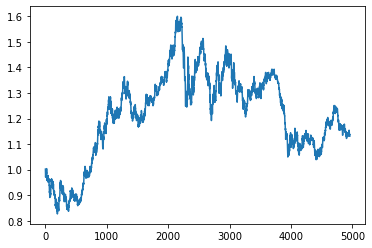

In [152]:
#Importing and Cleaning Data
hist_data = pd.read_csv('EUR_USD Historical Data.csv')
hist_data.rename(columns = {'Price': 'Close'}, inplace = True)
hist_data = hist_data[['Date', 'Open', 'Close', 'High', 'Low', 'Change %']]
'''
print(hist_data)
plt.plot(hist_data['Open'])
plt.show()
'''

#Time-Index Representation
colNames = hist_data.columns.tolist()
for i in colNames:
    hist_data[i] = hist_data[i].values[::-1]
print(hist_data)

plt.plot(hist_data['Open'])

Our Hidden Markov Model will be implemented using two variables to reflect its current state, along wtih 2 hidden states.
The hidden states is the upcoming price movement, for which we have chosen a binary variable, representing either a rise or drop in spot price.

The first observable variable is Price Momentum (reflecting the underlying belief that this trend will continue), broken down into two states of price movement being greater than an arbitrary value, less tha than the negative of the value, or between the positive and negative, respectively representing a rise, drop, or constant.

The second observable variable is Mean Reversion (or the underlying tendency for values (prices) to revert to some sort of average). This is reflected in 3 states (Higher, equal, or lower), meausring mean displacement relative to an arbitrary value, x, is used.

In total, this creates 9 observable states within our model.

***In future work, I plan on rebuilding the HMM to be exposed to other, potentially more suitable ARP (Defensive, Carry, etc...)***

In [153]:
#Calculating Price Momentum Data
hist_data['Price_Movement'] = hist_data['Open'] - hist_data['Close'].shift(1)
#Calculating Mean Reversion Data
hist_data['Mean_Reversion'] = hist_data['Open'] - hist_data.rolling(window = 10)['Close'].mean()


In [155]:
momentum = np.array(hist_data['Price_Movement'])
reversion = np.array(hist_data['Mean_Reversion'])
index = [0,1,2,3,4,5,6,7,8]

#Remove Null Values
momentum = np.delete(momentum, index)
reversion = np.delete(reversion, index)


In [163]:
def fitHMM(X, nSamples, lengths):
    # fit Gauassian HMM to X
    model = hmm.GaussianHMM(n_components=2, n_iter = 1000).fit(X, lengths)

    # classify each observation as state 0 or 1
    hidden_states = model.predict(X, lengths)
 
    # find parameters of Gaussian HMM
    mus = np.array(model.means_)
    sigmas = np.array(np.sqrt(np.array([np.diag(model.covars_[0]),np.diag(model.covars_[1])])))
    P = np.array(model.transmat_)
 
    # find log-likelihood of Gaussian HMM
    logProb = model.score(X, lengths)
    
    # generate nSamples from Gaussian HMM
    samples,_ = model.sample(nSamples)
 
    return hidden_states, mus, sigmas, P, logProb, samples

Log Likelihood of State Trajectory: 41402.182332822515


Text(0, 0.5, 'Price Change in Basis Points')

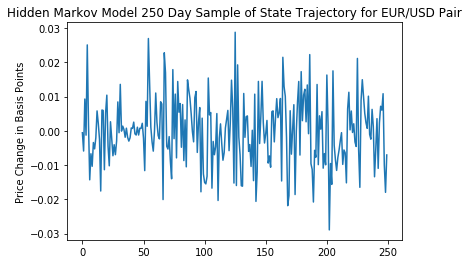

In [171]:
def extractVals(lst): 
    return [[el] for el in lst] 

X1 = extractVals(momentum)
X2 = extractVals(reversion)
Y = np.concatenate([X1,X2])
lengths = [len(X1), len(X2)]

hidden_states, mus, sigmas, P, logProb, samples = fitHMM(Y, 250, lengths)
print('Log Likelihood of State Trajectory:', logProb)

plt.plot(np.arange(250), samples[:,0])
plt.title('Hidden Markov Model 250 Day Sample of State Trajectory for EUR/USD Pair')
plt.ylabel('Price Change in Basis Points')

In [ ]:
#BackTesting

#Discretize Signals
#-1 Represents an Upcoming Price Drop
#1 Represents an Upcoming Price Increase

